In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [32]:
role = get_execution_role()
data_path = 'chirps.csv'
pddf = pd.read_csv(data_path)
pd.read_csv(data_path)

,chirps,temp
0,20.000000,88.599998
1,16.000000,71.599998
2,19.799999,93.300003
3,18.400000,84.300003
4,17.100000,80.599998
5,15.500000,75.199997
6,14.700000,69.699997
7,17.100000,82.000000
8,15.400000,69.400002
9,16.200001,83.300003


In [5]:
df = sqlc.createDataFrame(pd.read_csv(data_path))

In [6]:
df

DataFrame[chirps: double, temp: double]

### Write parquet to s3

In [7]:
parquetPath = '/home/ec2-user/SageMaker/tmp-pqt_jcn4rh'
df.write.parquet(parquetPath)
#change path for when i actually do hw

In [9]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]
bucket='odl-spark19spds6003-001'
s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sample_data/pqt/"+f)


### Write to spark dataframe from parquet

In [10]:
df = sqlc.read.parquet(parquetPath)

In [11]:
df

DataFrame[chirps: double, temp: double]

In [12]:
display(df)

DataFrame[chirps: double, temp: double]

In [13]:
df.printSchema()

root
 |-- chirps: double (nullable = true)
 |-- temp: double (nullable = true)



In [14]:
df.take(5)

[Row(chirps=20.0, temp=88.59999847),
 Row(chirps=16.0, temp=71.59999847),
 Row(chirps=19.79999924, temp=93.30000305),
 Row(chirps=18.39999962, temp=84.30000305),
 Row(chirps=17.10000038, temp=80.59999847)]

In [15]:
print("Pearson's r(chirps,temp) = {}".format(df.corr("chirps", "temp")))

Pearson's r(chirps,temp) = 0.8351437870311545


In [17]:
df = df.select("chirps","temp")

In [18]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 11, test set N = 4


In [20]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy

In [22]:
# make a user defined function (udf)
#probably wont work when i copy and paste 
#says ill have to google thingsSS
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("chirps", "oneElementVec(temp) as temp")
testDF = testDF.selectExpr("chirps", "oneElementVec(temp) as temp")

print(testDF.orderBy(testDF.chirps.desc()).limit(5))

DataFrame[chirps: double, temp: vector]


## Train Test Split

In [23]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("chirps", "label").withColumnRenamed("temp", "features")
testDF = testDF.withColumnRenamed("chirps", "label").withColumnRenamed("temp", "features")

# Fit Model

In [30]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.22108590129536349]
Intercept: -0.8644559899285685


## Model Evaluation

In [31]:
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.953066
r2: 0.746568


In [26]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=17.20000076, features=DenseVector([82.6]), prediction=17.397239118807025), Row(label=17.10000038, features=DenseVector([82.0]), prediction=17.264587916291237), Row(label=16.20000076, features=DenseVector([83.3]), prediction=17.55200026228721), Row(label=16.0, features=DenseVector([80.6]), prediction=16.9550673162163)]


## Visualization

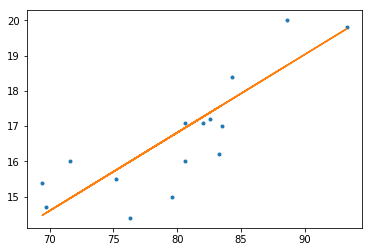

In [37]:
import matplotlib.pyplot as plt


%matplotlib inline  
# Fit with polyfit
m, b = .221, -.8645

plt.plot(pddf.temp, pddf.chirps, '.')
plt.plot(pddf.temp, b + m * pddf.temp, '-')
plt.show()